# 实验4 RNN 深度学习

## 1. 时序数据生成

In [1]:
# 导入依赖包
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.metrics import mean_absolute_error as mae

# 配置 matplotlib显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# # 默认设置double tensor，便于反向传播时保持数值精度
# torch.set_default_dtype(torch.double)

# # 固定随机种子，确保实验结果可重复
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

print(f"PyTorch version: {torch.__version__}")


PyTorch version: 2.9.0+cu130


In [2]:
# 定义绘制序列函数
def plot_series(time, series, format="-", start=0, end=None, label=None):
    """
    根据时间轴和对应数据列表绘制序列图像

    参数:
    time: 时间轴数据，一维数组，表示时间点
    series: 时间序列数据，一维数组，与time长度相同，表示对应时刻的值
    format: 线条格式，默认为实线"-"，可选"--"虚线、":"点线等
    start: 绘图的起始索引，默认为0，用于局部绘制
    end: 绘图的结束索引，默认为None（绘制到末尾）
    label: 图例标签，用于区分多条曲线
    """

    # 绘制时间序列曲线
    plt.plot(time[start:end], series[start:end], format, label=label)

    # 设置横纵坐标轴标签
    plt.xlabel("Time")
    plt.ylabel("Value")

    # 如果提供了标签，则显示图例
    if label:
        plt.legend(fontsize=14)

    # 显示网格，便于观察数据点和趋势
    plt.grid(True)


In [3]:
# 趋势模式生成
def trend(time, slope=0):
    """线性趋势：值随时间线性变化。"""
    return slope * time

# 噪声模式生成
def white_noise(time, noise_level=1, seed=None):
    """生成 N(0, 1) 的白噪声，并用 noise_level 控制幅值。"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [4]:
# 季节性模式生成
def seasonal_pattern(season_time):
    """定义一个周期内的季节性模式
    - 前40%的周期使用cos模拟周期波动
    - 后面部分指数衰减模拟下降趋势
    """
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),  # 前40%: 余弦波动
                    np.exp(-3 * season_time))          # 后60%: 指数衰减

def seasonality(time, period, amplitude=1, phase=0):
    """
    将季节性模式循环多次生成完整时间序列
    
    参数:
    time: 时间轴数组
    period: 周期长度，如365表示年度周期
    amplitude: 振幅，控制季节性波动的强度
    phase: 相位偏移，控制季节性模式的起始位置，默认为0
    
    返回:
    完整的季节性时间序列
    
    工作原理:
    1. 将时间映射到[0, 1]的周期内：((time + phase) % period) / period
    2. 应用seasonal_pattern函数获取基础模式
    3. 乘以振幅得到最终的季节性序列
    """
    # 计算归一化的季节时间，通过取模实现周期性重复
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

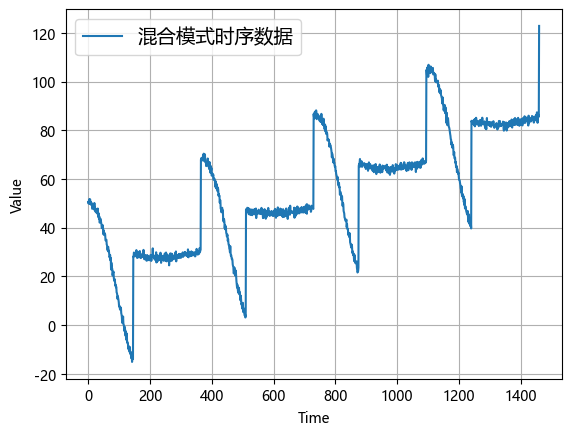

In [5]:
"""
生成实验用的混合模式时序数据
这是最终用于训练和测试的数据集
结合了趋势、季节性和噪声三种成分
"""

# 重新生成时间轴，确保数据一致性
time = np.arange(4 * 365 + 1)  # 1461个时间点

# 设置各成分参数
baseline = 10         # 基线值
slope = 0.05          # 较小的上升趋势，模拟缓慢增长
amplitude = 40        # 季节性振幅
noise_level = 1       # 较小的噪声水平，保持主要模式可见

# 生成混合序列：基线 + 趋势 + 季节性 + 噪声
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) + white_noise(time, noise_level, seed=SEED)

# 显示最终生成的时序数据
plot_series(time, series, label='混合模式时序数据')

## 2. 数据处理


In [6]:
# 定义device：优先使用GPU，如果不可用则使用CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [7]:
# 数据预处理
# 设置训练集和测试集的划分比例
split_prop = 0.7
train_data = series[:int(split_prop * int(series.size))]
test_data = series[int(split_prop * int(series.size)):]

## 数据归一化处理
# 对训练集进行归一化：将数据缩放到 [0,1] 范围
train_data_normalized = (train_data - train_data.min()) / (train_data.max() - train_data.min())
# Min-Max归一化：(x - min) / (max - min)
# 将训练集数据线性变换到 [0,1] 区间
# 有利于神经网络训练的稳定性和收敛速度

# 对测试集进行归一化：使用训练集的统计量
test_data_normalized = (test_data - train_data.min()) / (train_data.max() - train_data.min())
# 使用训练集的 min 和 max 来归一化测试集
# 这是为了避免数据泄漏，确保模型评估的公正性
# 在实际应用中，测试数据的分布应该是未知的

In [8]:
# 滑动窗口采样
# 初始化训练集和测试集的输入、输出列表
train_x = []
train_y = []
test_x = []
test_y = []
i = 0

time_step = 5    # 输入序列长度（时间步数）
output_size = 1  # 输出序列长度（时间步数）
batch_size = 128  # 批次大小

# 遍历训练数据，创建输入-输出样本对
while (i + time_step + output_size < len(train_data_normalized)):
    # 每次滑动一个步长，从位置 i 开始，取 time_step 个时间步的数据
    train_x.append(train_data_normalized[i : i + time_step])
    # 输出序列：从 i+time_step 开始，取 output_size 个时间步的数据
    train_y.append(train_data_normalized[i + time_step : i + time_step + output_size])
    i += output_size  # 每次跳过 output_size 个时间步，步长为 output_size（1）

# 对测试数据进行滑动窗口采样
# 遍历测试数据，创建输入-输出样本对
j = 0
while (j + time_step + output_size < len(test_data_normalized)):
    # 每次滑动一个步长，从位置 j 开始，取 time_step 个时间步的数据
    test_x.append(test_data_normalized[j : j + time_step])
    # 输出序列：从 j+time_step 开始，取 output_size 个时间步的数据
    test_y.append(test_data_normalized[j + time_step : j + time_step + output_size])
    j += output_size  # 每次跳过 output_size 个时间步，步长为 output_size（1）

print(f'train_x={np.array(train_x).shape}')
print(f'train_y={np.array(train_y).shape}')
print(f'test_x={np.array(test_x).shape}')
print(f'test_y={np.array(test_y).shape}')

train_x=(1016, 5)
train_y=(1016, 1)
test_x=(433, 5)
test_y=(433, 1)


In [9]:
# 装入数据
# 将数据从列表转换为PyTorch张量格式
train_x = torch.tensor(train_x, dtype=torch.float32)  # 训练集输入特征
train_y = torch.tensor(train_y, dtype=torch.float32)  # 训练集输出标签
test_x = torch.tensor(test_x, dtype=torch.float32)    # 测试集输入特征
test_y = torch.tensor(test_y, dtype=torch.float32)    # 测试集输出标签

# 创建训练数据集 TensorDataset：PyTorch数据集类，将特征和标签打包成数据集
train_dataset = TensorDataset(train_x, train_y)

# 创建数据加载器 DataLoader：用于批量加载训练数据
train_loader = DataLoader(
    dataset=train_dataset,        # 使用的数据集
    batch_size=batch_size,        # 每个批次的样本数量，之前设置为128
    shuffle=True,                 # 每个epoch打乱数据顺序，防止模型学习到数据顺序
    num_workers=0                 # 用于数据加载的子进程数，0表示在主进程中加载
)


C:\Users\Alstar\AppData\Local\Temp\ipykernel_78656\1051672855.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  train_x = torch.tensor(train_x, dtype=torch.float32)  # 训练集输入特征


## 3.RNN模拟数据预测

In [10]:
# 构建RNN网络
class MYRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, time_step):
        super(MYRNN, self).__init__()
        self.input_size = input_size          # 输入特征维度（例如：1，表示温度值）
        self.hidden_size = hidden_size        # RNN隐藏层维度（例如：256）
        self.output_size = output_size        # 输出维度（例如：1，预测温度）
        self.time_step = time_step            # 序列长度（例如：5，使用5小时数据）

        # 创建RNN层和linear层，RNN层提取特征，linear层用作最后的预测
        self.rnn = nn.RNN(
            input_size=self.input_size,       # 输入特征维度
            hidden_size=self.hidden_size,     # 隐藏层维度
            num_layers=1,                     # RNN层数，1表示单层RNN
            batch_first=True,                 # 输入形状为[batch_size, seq_len, input_size]
        )
        self.out = nn.Linear(self.hidden_size, self.output_size)  # 全连接输出层

    def forward(self, x):
        """
        输入: [batch_size, time_step, input_size]
        输出: [batch_size, output_size]
        """
        # 获得RNN的计算结果，r_out包含所有时间步的输出，h_n是最后一个时间步的隐藏状态
        r_out, _ = self.rnn(x)  # 忽略隐藏状态h_n，只使用输出r_out=[batch_size, time_step, hidden_size]
        # 将RNN输出重塑为二维张量，便于全连接层处理
        r_out = r_out.reshape(-1, self.hidden_size)  # [batch_size * time_step, hidden_size]
        # 通过全连接层进行预测
        out = self.out(r_out)  # [batch_size * time_step, output_size]
        # 将输出恢复成三维张量
        out = out.reshape(-1, self.time_step, self.output_size)  # [batch_size, time_step, output_size]
        # 返回所有batch中最后一个时间步的预测结果
        return out[:, -1, :]  # [batch_size, output_size]

In [11]:
# 参数设置
input_size = 1
hidden_size = 256
output_size = 1
epochs = 200
lr = 0.001
batch_size = 128
time_step = 5

# 模型参数初始化
# 实例化神经网络
net = MYRNN(input_size, hidden_size, output_size, time_step)
# 初始化网络参数
for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)
# 设置损失函数
loss = nn.MSELoss()
# 设置优化器（推荐使用Adam）
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# 使用GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")  # 添加设备信息输出

# 将网络移动到设备
net.to(device)

使用设备: cuda:0


MYRNN(
  (rnn): RNN(1, 256, batch_first=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

In [12]:
# 训练模型
train_loss = []  # 记录每个epoch的训练损失
test_loss = []   # 记录每个epoch的测试损失

# 开始训练
for epoch in range(epochs):
    train_l = []
    test_l = 0

    for x, y in train_loader:
        # 将训练数据移动到设备（GPU或CPU）
        x = torch.unsqueeze(x, dim=2)
        x = x.to(device)
        y = y.to(device)

        y_predict = net(x)  # 前向传播
        l = loss(y_predict, y)

        optimizer.zero_grad()
        l.backward()  # 反向传播
        optimizer.step()  # 更新参数

        train_l.append(l.item())  # 记录当前batch的损失

    # 每个epoch结束后在测试集上评估模型性能
    with torch.no_grad():
        # 将测试数据移动到设备
        test_x_temp = torch.unsqueeze(test_x, dim=2)
        test_x_temp = test_x_temp.to(device)
        test_y_temp = test_y.to(device)
        # 测试集前向传播
        test_predict = net(test_x_temp)
        # 计算测试损失
        test_l = loss(test_predict, test_y_temp)
        mae_nn = mae(test_y, test_predict.to('cpu'))

    # 打印训练进度
    print("Epoch%d: train loss=%.5f, test loss=%.5f" % (epoch + 1, np.array(train_l).mean(), test_l.item()))
    # 记录损失历史
    train_loss.append(np.array(train_l).mean())
    test_loss.append(test_l.item())
print(f"mae={mae_nn}")

Epoch1: train loss=0.23025, test loss=0.01537
Epoch2: train loss=0.05974, test loss=0.23095
Epoch3: train loss=0.03821, test loss=0.06275
Epoch4: train loss=0.02713, test loss=0.05916
Epoch5: train loss=0.02239, test loss=0.09150
Epoch6: train loss=0.01888, test loss=0.03978
Epoch7: train loss=0.01494, test loss=0.03195
Epoch8: train loss=0.01144, test loss=0.01736
Epoch9: train loss=0.00698, test loss=0.00485
Epoch10: train loss=0.00334, test loss=0.00305
Epoch11: train loss=0.00318, test loss=0.00225
Epoch12: train loss=0.00270, test loss=0.00439
Epoch13: train loss=0.00255, test loss=0.00326
Epoch14: train loss=0.00252, test loss=0.00336
Epoch15: train loss=0.00253, test loss=0.00245
Epoch16: train loss=0.00250, test loss=0.00228
Epoch17: train loss=0.00250, test loss=0.00306
Epoch18: train loss=0.00249, test loss=0.00221
Epoch19: train loss=0.00245, test loss=0.00256
Epoch20: train loss=0.00244, test loss=0.00247
Epoch21: train loss=0.00243, test loss=0.00249
Epoch22: train loss=0.

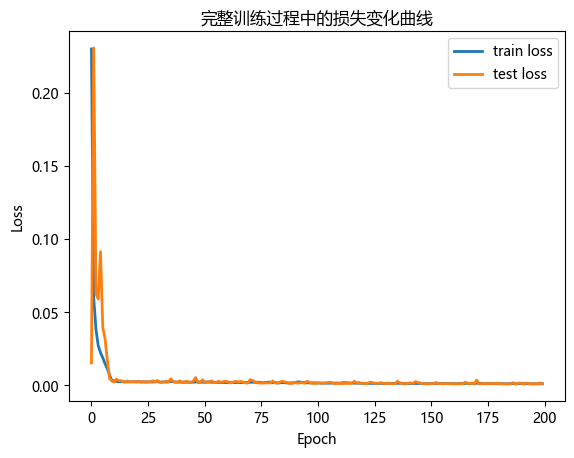

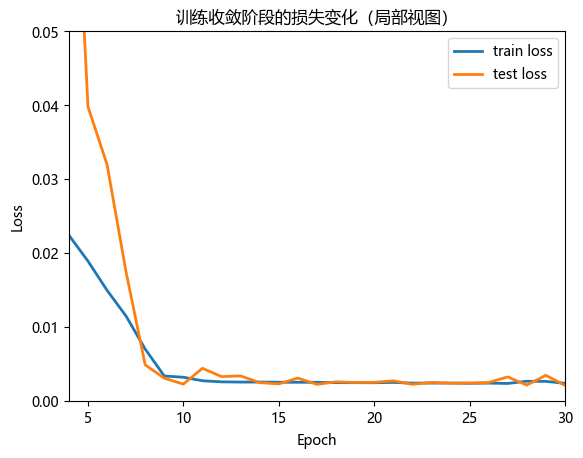

torch.Size([433, 5])


In [13]:
# 绘制loss曲线
import matplotlib.pyplot as plt
# 画出训练和测试的loss趋势图
plt.plot(range(epochs), train_loss, label="train loss", linewidth=2)
plt.plot(range(epochs), test_loss, label="test loss", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("完整训练过程中的损失变化曲线")
plt.show()


# 绘制loss曲线（局部放大）
plt.plot(range(epochs), train_loss, label="train loss", linewidth=2)
plt.plot(range(epochs), test_loss, label="test loss", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.xlim(4, 30)  # 设置x轴显示范围：从第10轮到第75轮
plt.ylim(0, 0.05)  # 设置y轴显示范围：从0到0.2

plt.legend()  # 显示图例，区分训练损失和测试损失
plt.title("训练收敛阶段的损失变化（局部视图）")
plt.show()  # 显示局部Loss趋势图

print(test_x.shape)


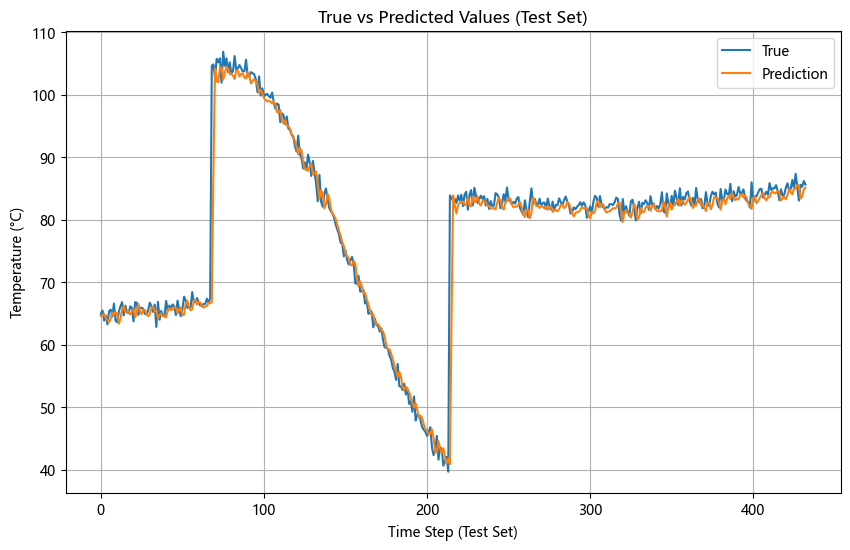

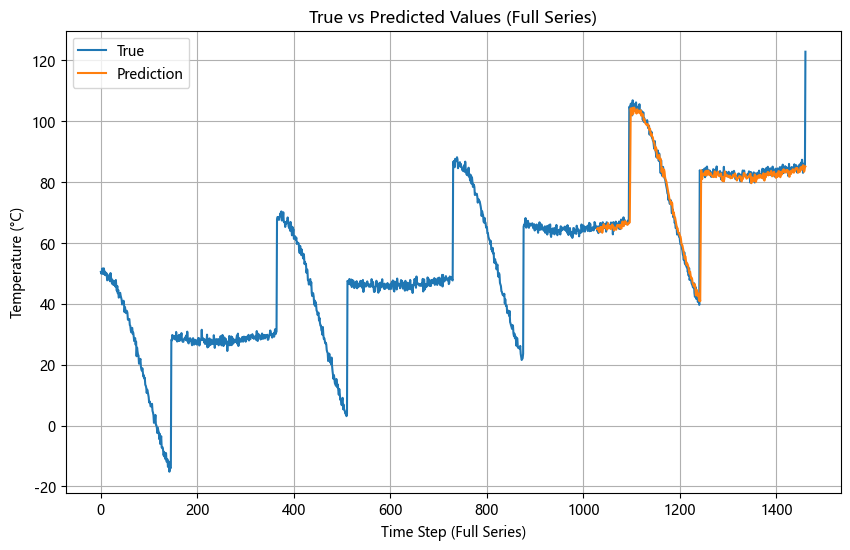

In [14]:
# 预测对比
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10  # 设置图形宽度为10英寸
fig_size[1] = 6   # 设置图形高度为6英寸
plt.rcParams['figure.figsize'] = fig_size  # 全局设置matplotlib的默认图形大小

# 预测结果
test_x = torch.unsqueeze(test_x, dim=2)  # [433, 5, 1]
test_x = test_x.to(device)          # 将测试数据移动到计算设备
predict = net(test_x)               # 使用训练好的模型进行预测

# 逆归一化：将预测值转换回原始数据尺度
predict = predict.cpu().detach().numpy() * (train_data.max() - train_data.min()) + train_data.min()
# 不覆盖 test_y，单独拷贝做反归一化
test_y_np = test_y.cpu().numpy() * (train_data.max() - train_data.min()) + train_data.min()

predict_result = []
test_y_result = []
for item in predict:
    predict_result += list(item)
for item in test_y_np:
    test_y_result += list(item)

# 可视化对比
plt.plot(range(len(test_y_result)), test_y_result, label='True')
plt.plot(range(len(predict_result)), predict_result, label='Prediction')
plt.xlabel("Time Step (Test Set)")
plt.ylabel("Temperature (°C)")
plt.grid(True)  # 添加网格线，便于读数
plt.legend()
plt.title("True vs Predicted Values (Test Set)")
plt.show()

# 与整体数据进行比较
plt.plot(range(len(series)), series, label='True')
start_idx = len(series) - len(predict_result)  # 计算预测结果在整体序列中的起始位置
plt.plot(range(start_idx, len(series)), predict_result, label='Prediction')
plt.xlabel("Time Step (Full Series)")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.title("True vs Predicted Values (Full Series)")
plt.show()


## 4.真实数据处理

In [15]:
# 读取原始文件，并将日期列设为索引
# na_values="+9999.9", "9", "+9999.9","9999","9"识别为缺失值
data = pd.read_csv("data_exp04_V2.csv", index_col="DATE", na_values="+9999.9, 9")
data = data["TMP"]  # 选取气温（TMP）一列，只保留温度数据

# 将data.index设置为时间索引，便于时间序列操作
data.index = pd.to_datetime(data.index)
# 设置开始与结束时间，选择特定时间段的数据进行分析
start_time = pd.to_datetime("2019-01-01 00:00:00")
end_time = pd.to_datetime("2019-06-30 23:00:00")
data = data[start_time:end_time]  # 切片操作，选取2019年上半年的数据

# 从data中剔除TMP列为NaN的数据，清理缺失值
data = data.dropna()

# 数据格式转换：将TMP数据从字符串转为整数，并获取正确的数值
data = data.str.split(",", expand=True)[0]   # 按逗号分割字符串，取第一部分
data = data.astype("int") / 10               # 转换为整数后除以10，得到实际温度值（可能是华氏度转摄氏度）

# 将时间补齐（期间有丢失的整点数据），并将时间间隔设置为1小时，重新设置data的索引
time = pd.date_range(start=start_time, end=end_time, freq="h")
data = data.reindex(time)  # 重新索引并对齐数据，缺失位置会填充NaN

# 进行线性插值，补全重新索引后仍存在的缺失数据
data = data.interpolate()   # 对缺失的整点的线性插值来填充NaN值

# 处理好的pandas Series数据转换为numpy array类型，与前面实验的数据格式保持一致
series = np.array(data)

C:\Users\Alstar\AppData\Local\Temp\ipykernel_78656\3805885984.py:3: DtypeWarning: Columns (4,6,7,8,9,10,11,12,13,14,17,18,20,21,22,23,25,26,27,28,29,31,32,33,34,35,36,37,39,41,45,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data_exp04_V2.csv", index_col="DATE", na_values="+9999.9, 9")


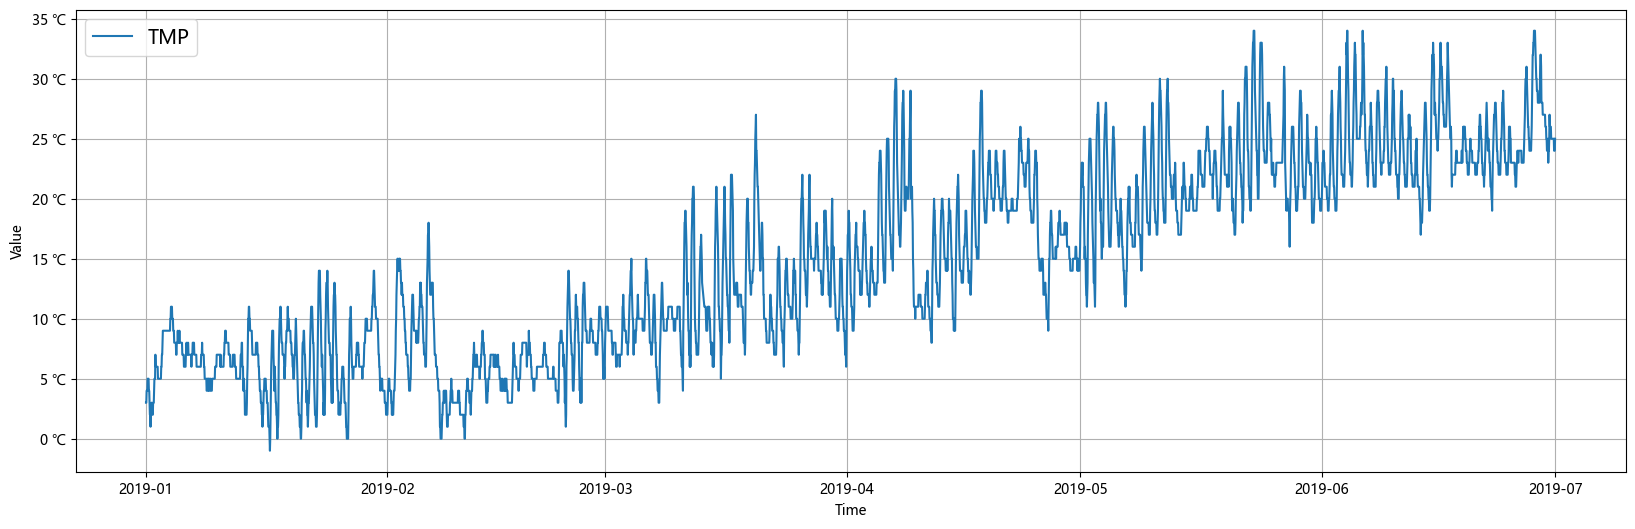

In [16]:
# 导入刻度格式化模块，用于自定义坐标轴显示格式
import matplotlib.ticker as mticker

# 数据可视化
fig, ax = plt.subplots(figsize=(20, 6))
# 设置纵轴单位格式
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d ℃'))
# 自定义Y轴刻度标签格式：
# - mticker.FormatStrFormatter: 使用字符串格式化刻度标签
# - '%d ℃'：格式字符串，%d表示将数值格式化为整数，℃表示温度单位

# 绘制时间序列数据
plot_series(time, series, label='TMP')
plt.show()


## 5.LSTM预测气温 数据处理

In [17]:
# 参数设置
input_size = 1
hidden_size = 128
output_size = 1
epochs = 100
lr = 0.05
batch_size = 20
time_step = 12
# 划分数据集
# 前140天用作训练（每天24小时数据）
train_data = data[0:140 * 24]
# 剩下的时间用作测试
test_data = data[140 * 24:]

# 数据归一化处理
train_data_normalized = (train_data - train_data.min()) / (train_data.max() - train_data.min())
test_data_normalized = (test_data - train_data.min()) / (train_data.max() - train_data.min())

In [18]:
# 滑动窗口采样
# 初始化训练集和测试集的输入、输出列表
train_x = []
train_y = []
test_x = []
test_y = []
i = 0

# 遍历训练数据，创建输入-输出样本对
while (i + time_step + output_size < len(train_data_normalized)):
    # 每次滑动一个步长，从位置 i 开始，取 time_step 个时间步的数据
    train_x.append(train_data_normalized[i : i + time_step])
    # 输出序列：从 i+time_step 开始，取 output_size 个时间步的数据
    train_y.append(train_data_normalized[i + time_step : i + time_step + output_size])
    i += output_size  # 每次跳过 output_size 个时间步，步长为 output_size（1）

# 对测试数据进行滑动窗口采样
# 遍历测试数据，创建输入-输出样本对
j = 0
while (j + time_step + output_size < len(test_data_normalized)):
    # 每次滑动一个步长，从位置 j 开始，取 time_step 个时间步的数据
    test_x.append(test_data_normalized[j : j + time_step])
    # 输出序列：从 j+time_step 开始，取 output_size 个时间步的数据
    test_y.append(test_data_normalized[j + time_step : j + time_step + output_size])
    j += output_size  # 每次跳过 output_size 个时间步，步长为 output_size（1）

print(f'train_x={np.array(train_x).shape}')
print(f'train_y={np.array(train_y).shape}')
print(f'test_x={np.array(test_x).shape}')
print(f'test_y={np.array(test_y).shape}')

train_x=(3347, 12)
train_y=(3347, 1)
test_x=(971, 12)
test_y=(971, 1)


In [19]:
# 装入数据
# 将数据从列表转换为PyTorch张量格式
train_x = torch.tensor(train_x, dtype=torch.float32)  # 训练集输入特征
train_y = torch.tensor(train_y, dtype=torch.float32)  # 训练集输出标签
test_x = torch.tensor(test_x, dtype=torch.float32)    # 测试集输入特征
test_y = torch.tensor(test_y, dtype=torch.float32)    # 测试集输出标签

# 创建训练数据集 TensorDataset：PyTorch数据集类，将特征和标签打包成数据集
train_dataset = TensorDataset(train_x, train_y)

# 创建数据加载器 DataLoader：用于批量加载训练数据
train_loader = DataLoader(
    dataset=train_dataset,        # 使用的数据集
    batch_size=batch_size,        # 每个批次的样本数量，之前设置为128
    shuffle=True,                 # 每个epoch打乱数据顺序，防止模型学习到数据顺序
    num_workers=0                 # 用于数据加载的子进程数，0表示在主进程中加载
)

C:\Users\Alstar\AppData\Local\Temp\ipykernel_78656\717675967.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_x = torch.tensor(train_x, dtype=torch.float32)  # 训练集输入特征
C:\Users\Alstar\AppData\Local\Temp\ipykernel_78656\717675967.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_y = torch.tensor(train_y, dtype=torch.float32)  # 训练集输出标签
C:\Users\Alstar\AppData\Local\Temp\ipykernel_78656\717675967.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by p

## 6.LSTM预测气温

In [20]:
# 构建LSTM网络
class MYLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, time_step):

        super(MYLSTM, self).__init__()
        self.input_size = input_size      # 输入特征维度（例如：1，表示温度值）
        self.hidden_size = hidden_size    # RNN隐藏层维度（例如：256）
        self.output_size = output_size    # 输出维度（例如：1，预测温度）
        self.time_step = time_step        # 序列长度（例如：5，使用5小时数据）

        # 创建RNN层和linear层，RNN层提取特征，linear层用作最后的预测
        self.lstm = nn.LSTM(
            input_size=self.input_size,    # 输入特征维度
            hidden_size=self.hidden_size,  # 隐藏层维度
            num_layers=1,                  # RNN层数，1表示单层RNN
            batch_first=True,              # 输入形状为[batch_size, seq_len, input_size]
            bidirectional=True,
        )
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)  # 全连接输出层

    def forward(self, x):
        """
        输入: [batch_size, time_step, input_size]
        输出: [batch_size, output_size]
        """
        # 获得RNN的计算结果，r_out包含所有时间步的输出，h_n是最后一个时间步的隐藏状态
        r_out, _ = self.lstm(x)  # 忽略隐藏状态h_n，只使用输出r_out=[batch_size, time_step, hidden_size]
        # 将RNN输出重塑为二维张量，便于全连接层处理
        r_out = r_out.reshape(-1, self.hidden_size * 2)  # [batch_size * time_step, hidden_size]
        # 通过全连接层进行预测
        out = self.out(r_out)  # [batch_size * time_step, output_size]
        # 将输出恢复成三维张量
        out = out.reshape(-1, self.time_step, self.output_size)  # [batch_size, time_step, output_size]
        # 返回所有batch中最后一个时间步的预测结果
        return out[:, -1, :]  # [batch_size, output_size]

In [21]:
# 模型参数初始化
net = MYLSTM(input_size, hidden_size, output_size, time_step)

for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

loss = nn.MSELoss()

optimizer = torch.optim.SGD(net.parameters(), lr=lr)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)
print(f"使用设备: {device}")

# 训练模型
# 初始化损失记录列表
train_loss = []
test_loss = []

for epoch in range(epochs):
    train_l = []  # 存储当前epoch中每个batch的训练损失
    test_l = 0    # 存储当前epoch的测试损失

    for x, y in train_loader:
        x = torch.unsqueeze(x, dim=2)
        # 将x,y放入device中
        x = x.to(device)  # 将输入数据移动到计算设备（GPU/CPU）
        y = y.to(device)  # 将标签数据移动到计算设备

        y_predict = net(x)
        l = loss(y_predict, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        train_l.append(l.item())  # 记录当前batch的损失值

    test_x_temp = torch.unsqueeze(test_x, dim=2)
    test_x_temp = test_x_temp.to(device)  # 移动测试集输入到设备
    test_y_temp = test_y.to(device)       # 移动测试集标签到设备

    # 得到测试集的预测结果
    test_predict = net(test_x_temp)  # 在测试集上进行预测

    # 计算测试集loss
    test_l = loss(test_predict, test_y_temp)  # 计算测试集上的损失

    # 打印训练进度
    print("Epoch%d:train loss=%.5f, test loss=%.5f" % (epoch + 1, np.array(train_l).mean(), test_l.item()))

    # 记录损失历史
    train_loss.append(np.array(train_l).mean())  # 记录当前epoch的平均训练损失
    test_loss.append(test_l.item())              # 记录当前epoch的测试损失

使用设备: cuda:0
Epoch1:train loss=0.04992, test loss=0.16522
Epoch2:train loss=0.04363, test loss=0.16563
Epoch3:train loss=0.04225, test loss=0.17947
Epoch4:train loss=0.04016, test loss=0.16472
Epoch5:train loss=0.03642, test loss=0.12543
Epoch6:train loss=0.02995, test loss=0.09437
Epoch7:train loss=0.02085, test loss=0.05005
Epoch8:train loss=0.01156, test loss=0.02429
Epoch9:train loss=0.00556, test loss=0.00770
Epoch10:train loss=0.00339, test loss=0.00477
Epoch11:train loss=0.00292, test loss=0.00342
Epoch12:train loss=0.00283, test loss=0.00316
Epoch13:train loss=0.00278, test loss=0.00313
Epoch14:train loss=0.00275, test loss=0.00326
Epoch15:train loss=0.00271, test loss=0.00338
Epoch16:train loss=0.00269, test loss=0.00314
Epoch17:train loss=0.00266, test loss=0.00327
Epoch18:train loss=0.00264, test loss=0.00318
Epoch19:train loss=0.00262, test loss=0.00308
Epoch20:train loss=0.00260, test loss=0.00301
Epoch21:train loss=0.00259, test loss=0.00287
Epoch22:train loss=0.00255, te

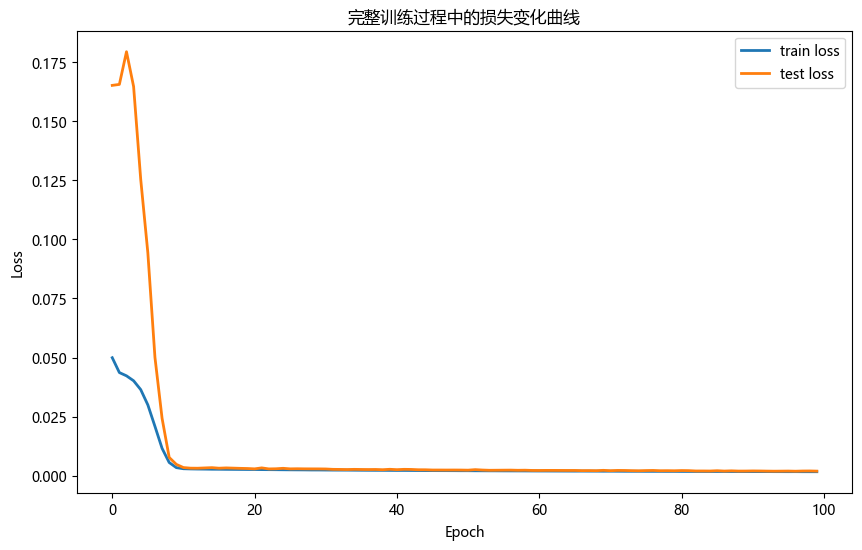

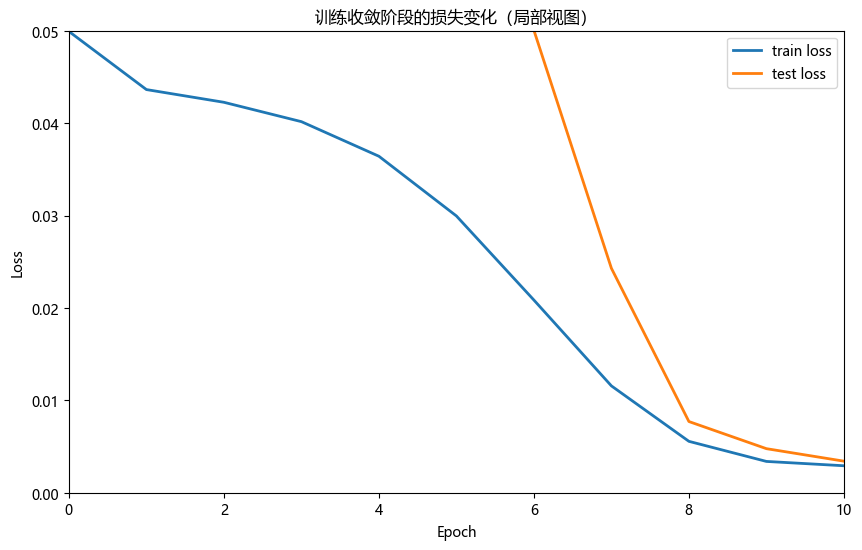

In [22]:
# 绘制loss曲线
plt.plot(range(epochs), train_loss, label="train loss", linewidth=2)
plt.plot(range(epochs), test_loss, label="test loss", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("完整训练过程中的损失变化曲线")
plt.show()

# 绘制loss曲线（局部放大）
plt.plot(range(epochs), train_loss, label="train loss", linewidth=2)
plt.plot(range(epochs), test_loss, label="test loss", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.xlim(0, 10)  # 设置x轴显示范围：从第10轮到第75轮
plt.ylim(0, 0.05)  # 设置y轴显示范围：从0到0.2

plt.legend()  # 显示图例，区分训练损失和测试损失
plt.title("训练收敛阶段的损失变化（局部视图）")
plt.show()  # 显示局部Loss趋势图

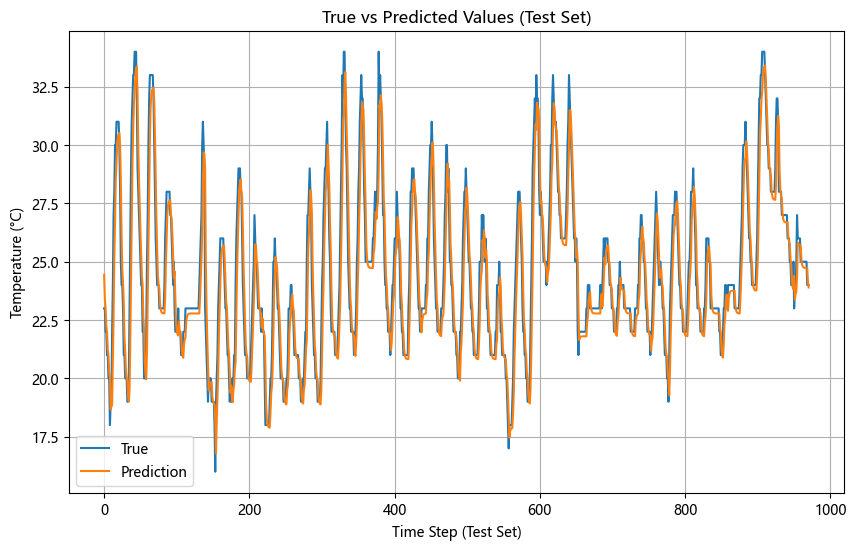

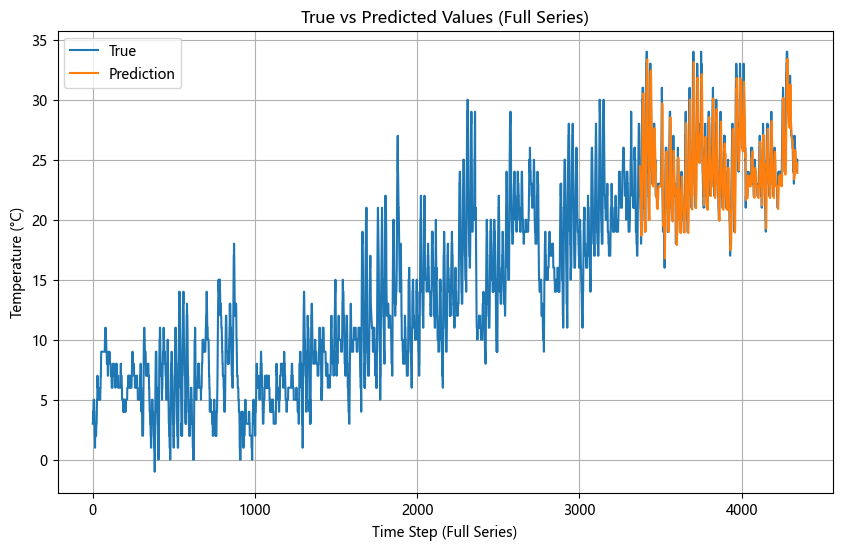

In [23]:
# 预测对比：过去 12 小时预测未来 1 小时
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10  # 设置图形宽度为10英寸
fig_size[1] = 6   # 设置图形高度为6英寸
plt.rcParams['figure.figsize'] = fig_size  # 全局设置matplotlib的默认图形大小

# 预测结果
test_x_temp = torch.unsqueeze(test_x, dim=2)
test_x_temp = test_x_temp.to(device)     # 将测试数据移动到计算设备
predict = net(test_x_temp)               # 使用训练好的模型进行预测

# 逆归一化：将预测值转换回原始数据尺度
predict = predict.cpu().detach().numpy() * (train_data.max() - train_data.min()) + train_data.min()
test_y_np = test_y.cpu().numpy() * (train_data.max() - train_data.min()) + train_data.min()

# 将数据从二维数组[[x1],[x2],...]转换为一维列表[x1,x2,x3...]
predict_result = []
test_y_result = []

for item in predict:
    predict_result += list(item)    # 将每个预测值添加到结果列表
for item in test_y_np:
    test_y_result += list(item)     # 将每个真实值添加到结果列表

# 可视化对比
plt.plot(range(len(test_y_result)), test_y_result, label='True')
plt.plot(range(len(predict_result)), predict_result, label='Prediction')
plt.xlabel("Time Step (Test Set)")
plt.ylabel("Temperature (°C)")
plt.grid(True)  # 添加网格线，便于读数
plt.legend()
plt.title("True vs Predicted Values (Test Set)")
plt.show()

# 与整体数据进行比较
plt.plot(range(len(series)), series, label='True')
start_idx = len(series) - len(predict_result)  # 计算预测结果在整体序列中的起始位置
plt.plot(range(start_idx, len(series)), predict_result, label='Prediction')
plt.xlabel("Time Step (Full Series)")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.title("True vs Predicted Values (Full Series)")
plt.show()

In [24]:
# LSTM气温预测：24 小时预测 3 小时
# 参数设置
time_step = 24
output_size = 3
batch_size = 20
epochs = 100

# 使用相同的训练/测试数据划分
train_x_24 = []
train_y_24 = []
test_x_24 = []
test_y_24 = []

# 训练数据滑动窗口采样
i = 0
while (i + time_step + output_size < len(train_data_normalized)):
    train_x_24.append(train_data_normalized[i : i + time_step])
    train_y_24.append(train_data_normalized[i + time_step : i + time_step + output_size])
    i += output_size

# 测试数据滑动窗口采样
j = 0
while (j + time_step + output_size < len(test_data_normalized)):
    test_x_24.append(test_data_normalized[j : j + time_step])
    test_y_24.append(test_data_normalized[j + time_step : j + time_step + output_size])
    j += output_size

# 转换为张量
train_x_24 = torch.tensor(train_x_24, dtype=torch.float32)
train_y_24 = torch.tensor(train_y_24, dtype=torch.float32)
test_x_24 = torch.tensor(test_x_24, dtype=torch.float32)
test_y_24 = torch.tensor(test_y_24, dtype=torch.float32)

# 创建数据加载器
train_dataset_24 = TensorDataset(train_x_24, train_y_24)
train_loader_24 = DataLoader(train_dataset_24, batch_size=batch_size, shuffle=True, num_workers=0)

print(f'train_x_24={train_x_24.shape}, train_y_24={train_y_24.shape}')
print(f'test_x_24={test_x_24.shape}, test_y_24={test_y_24.shape}')

train_x_24=torch.Size([1111, 24]), train_y_24=torch.Size([1111, 3])
test_x_24=torch.Size([319, 24]), test_y_24=torch.Size([319, 3])


C:\Users\Alstar\AppData\Local\Temp\ipykernel_78656\3546614531.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_x_24 = torch.tensor(train_x_24, dtype=torch.float32)
C:\Users\Alstar\AppData\Local\Temp\ipykernel_78656\3546614531.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_y_24 = torch.tensor(train_y_24, dtype=torch.float32)
C:\Users\Alstar\AppData\Local\Temp\ipykernel_78656\3546614531.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

In [25]:
# MYLSTM模型，修改output_size为3
net_24 = MYLSTM(input_size=1, hidden_size=128, output_size=output_size, time_step=time_step)
for param in net_24.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

loss = nn.MSELoss()
optimizer = torch.optim.SGD(net_24.parameters(), lr=0.05)
net_24.to(device)

# 训练模型
train_loss_24 = []
test_loss_24 = []

for epoch in range(epochs):
    train_l = []
    for x, y in train_loader_24:
        x = torch.unsqueeze(x, dim=2).to(device)
        y = y.to(device)
        y_predict = net_24(x)
        l = loss(y_predict, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        train_l.append(l.item())

    with torch.no_grad():
        test_x_24_temp = torch.unsqueeze(test_x_24, dim=2).to(device)
        test_y_24_temp = test_y_24.to(device)
        test_predict = net_24(test_x_24_temp)
        test_l = loss(test_predict, test_y_24_temp)
    
    print("Epoch%d: train loss=%.5f, test loss=%.5f" % (epoch + 1, np.array(train_l).mean(), test_l.item()))
    
    train_loss_24.append(np.array(train_l).mean())
    test_loss_24.append(test_l.item())

Epoch1: train loss=0.09146, test loss=0.22893
Epoch2: train loss=0.04503, test loss=0.18269
Epoch3: train loss=0.04415, test loss=0.17673
Epoch4: train loss=0.04394, test loss=0.17800
Epoch5: train loss=0.04378, test loss=0.17564
Epoch6: train loss=0.04381, test loss=0.16999
Epoch7: train loss=0.04350, test loss=0.17277
Epoch8: train loss=0.04353, test loss=0.16996
Epoch9: train loss=0.04370, test loss=0.16767
Epoch10: train loss=0.04341, test loss=0.17194
Epoch11: train loss=0.04305, test loss=0.16910
Epoch12: train loss=0.04283, test loss=0.17330
Epoch13: train loss=0.04285, test loss=0.16932
Epoch14: train loss=0.04254, test loss=0.16761
Epoch15: train loss=0.04237, test loss=0.16731
Epoch16: train loss=0.04220, test loss=0.16751
Epoch17: train loss=0.04186, test loss=0.16880
Epoch18: train loss=0.04156, test loss=0.15858
Epoch19: train loss=0.04109, test loss=0.15501
Epoch20: train loss=0.04062, test loss=0.15295
Epoch21: train loss=0.04019, test loss=0.15702
Epoch22: train loss=0.

C:\Users\Alstar\AppData\Local\Temp\ipykernel_78656\3164301916.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_y_24_np = np.array(test_y_24) * (train_data.max() - train_data.min()) + train_data.min()


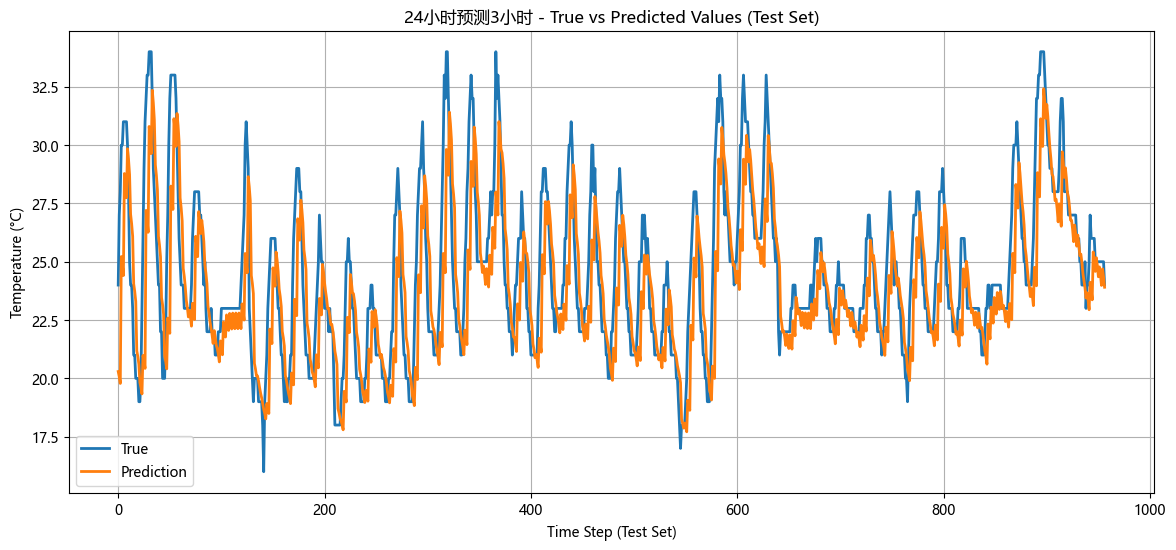

In [26]:
# 预测对比：24小时预测 3小时
test_x_24_temp = torch.unsqueeze(test_x_24, dim=2).to(device)
predict_24 = net_24(test_x_24_temp).cpu().detach().numpy()

# 逆归一化
predict_24 = predict_24 * (train_data.max() - train_data.min()) + train_data.min()
test_y_24_np = np.array(test_y_24) * (train_data.max() - train_data.min()) + train_data.min()

# 展平为一维
predict_result_24 = predict_24.flatten()
test_y_result_24 = test_y_24_np.flatten()

# 可视化
plt.figure(figsize=(14, 6))
plt.plot(range(len(test_y_result_24)), test_y_result_24, label='True', linewidth=2)
plt.plot(range(len(predict_result_24)), predict_result_24, label='Prediction', linewidth=2)
plt.xlabel("Time Step (Test Set)")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.title("24小时预测3小时 - True vs Predicted Values (Test Set)")
plt.show()

## 7.自建LSTM预测

In [27]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, time_step):
        super(CustomLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.time_step = time_step

        # 改为双层 LSTM + dropout
        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.2,
            bidirectional=False,
        )
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        """
        输入: [batch_size, time_step, input_size]
        输出: [batch_size, output_size]
        """
        r_out, (h_n, _) = self.lstm(x)
        # 取最后一层最后一个时间步的隐藏状态
        last_hidden = h_n[-1]  # [batch_size, hidden_size]
        out = self.out(last_hidden)
        return out

In [28]:
# 参数设置
input_size = 1
hidden_size = 128
output_size = 1
epochs = 100
lr = 0.001  # 降低学习率，换用Adam
batch_size = 20
time_step = 12

# 模型参数初始化
custom_net = CustomLSTM(input_size, hidden_size, output_size, time_step)

for param in custom_net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

loss = nn.MSELoss()

optimizer = torch.optim.Adam(custom_net.parameters(), lr=lr)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

custom_net.to(device)
print(f"使用设备: {device}")

# 训练模型
# 初始化损失记录列表
train_loss = []
test_loss = []

# 确保测试标签为当前设备上的张量
test_y_tensor = torch.as_tensor(test_y, dtype=torch.float32, device=device)
custom_net.train()

for epoch in range(epochs):
    custom_net.train()
    train_l = []
    test_l = 0

    for x, y in train_loader:
        x = torch.unsqueeze(x, dim=2).to(device)
        y = y.to(device)

        y_predict = custom_net(x)
        l = loss(y_predict, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        train_l.append(l.item())

    custom_net.eval()
    with torch.no_grad():
        test_x_temp = torch.unsqueeze(test_x, dim=2).to(device)
        test_y_temp = test_y_tensor
        test_predict = custom_net(test_x_temp)
        test_l = loss(test_predict, test_y_temp)
    custom_net.train()

    print("Epoch%d:train loss=%.5f, test loss=%.5f" % (epoch + 1, np.array(train_l).mean(), test_l.item()))
    train_loss.append(np.array(train_l).mean())
    test_loss.append(test_l.item())

使用设备: cuda:0
Epoch1:train loss=0.03385, test loss=0.02822
Epoch2:train loss=0.01154, test loss=0.01630
Epoch3:train loss=0.00696, test loss=0.00524
Epoch4:train loss=0.00301, test loss=0.00193
Epoch5:train loss=0.00207, test loss=0.00356
Epoch6:train loss=0.00176, test loss=0.00275
Epoch7:train loss=0.00157, test loss=0.00104
Epoch8:train loss=0.00139, test loss=0.00100
Epoch9:train loss=0.00135, test loss=0.00099
Epoch10:train loss=0.00119, test loss=0.00107
Epoch11:train loss=0.00114, test loss=0.00127
Epoch12:train loss=0.00110, test loss=0.00115
Epoch13:train loss=0.00106, test loss=0.00134
Epoch14:train loss=0.00102, test loss=0.00143
Epoch15:train loss=0.00095, test loss=0.00157
Epoch16:train loss=0.00101, test loss=0.00091
Epoch17:train loss=0.00100, test loss=0.00129
Epoch18:train loss=0.00094, test loss=0.00121
Epoch19:train loss=0.00092, test loss=0.00104
Epoch20:train loss=0.00097, test loss=0.00134
Epoch21:train loss=0.00090, test loss=0.00074
Epoch22:train loss=0.00088, te

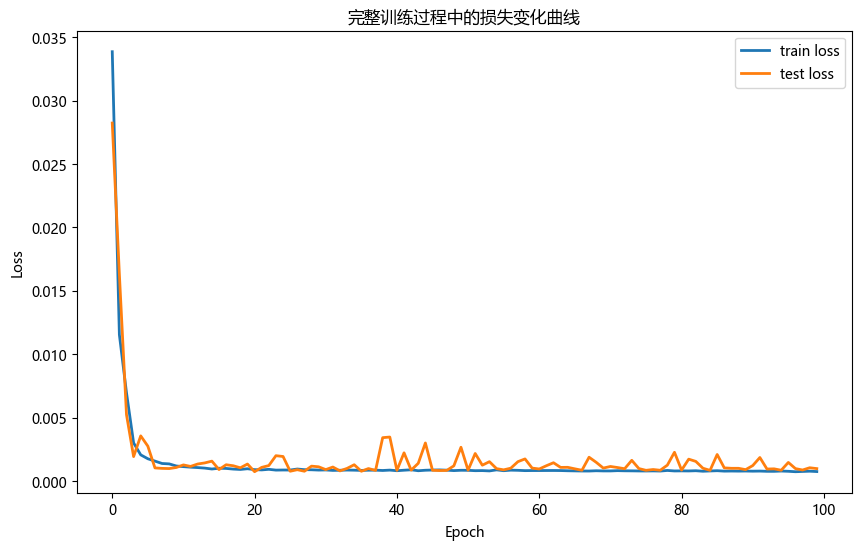

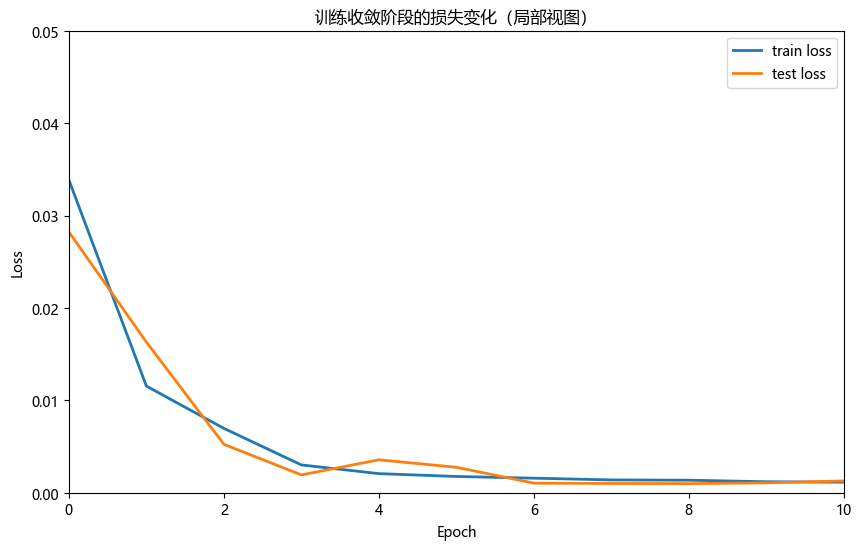

In [29]:
# 绘制loss曲线
plt.plot(range(epochs), train_loss, label="train loss", linewidth=2)
plt.plot(range(epochs), test_loss, label="test loss", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("完整训练过程中的损失变化曲线")
plt.show()

# 绘制loss曲线（局部放大）
plt.plot(range(epochs), train_loss, label="train loss", linewidth=2)
plt.plot(range(epochs), test_loss, label="test loss", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.xlim(0, 10)  # 设置x轴显示范围：从第10轮到第75轮
plt.ylim(0, 0.05)  # 设置y轴显示范围：从0到0.2

plt.legend()  # 显示图例，区分训练损失和测试损失
plt.title("训练收敛阶段的损失变化（局部视图）")
plt.show()  # 显示局部Loss趋势图

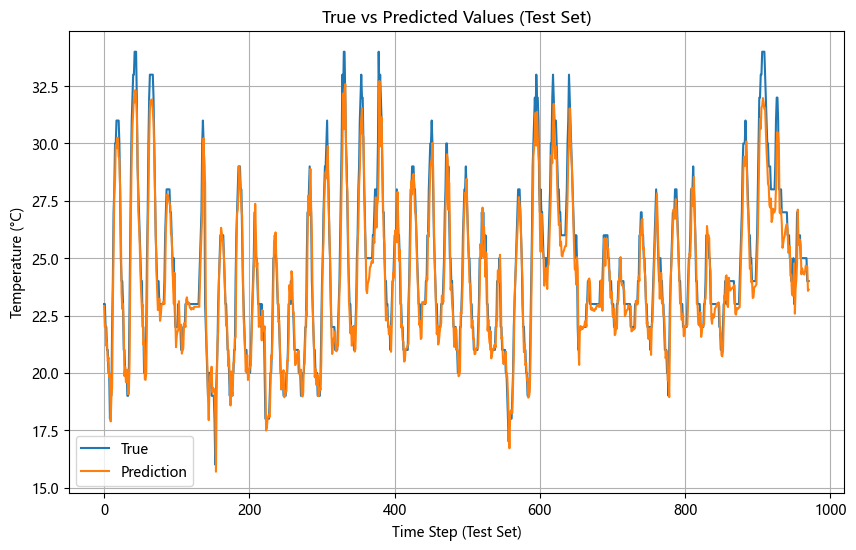

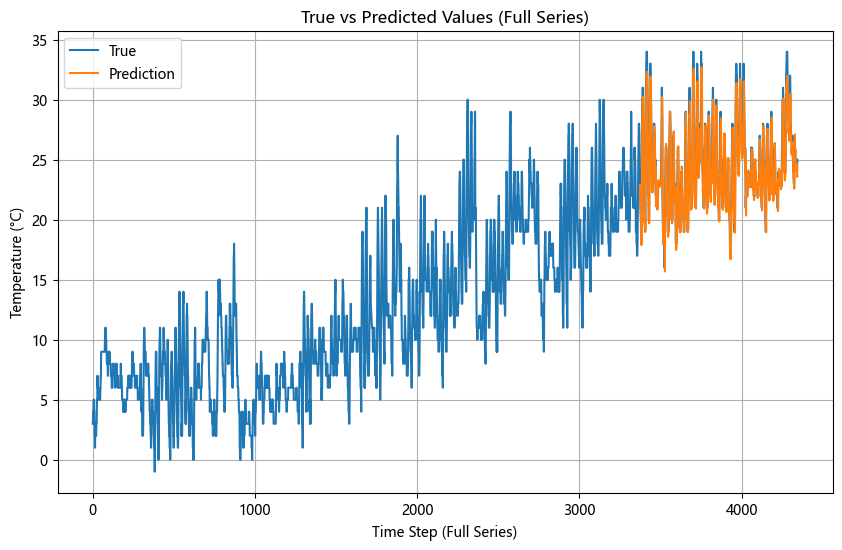

In [30]:
# 预测对比：过去 12 小时预测未来 1 小时
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10  # 设置图形宽度为10英寸
fig_size[1] = 6   # 设置图形高度为6英寸
plt.rcParams['figure.figsize'] = fig_size  # 全局设置matplotlib的默认图形大小

# 预测结果
test_x_temp = torch.unsqueeze(test_x, dim=2)
test_x_temp = test_x_temp.to(device)
custom_net.eval()
with torch.no_grad():
    predict = custom_net(test_x_temp)

# 逆归一化：将预测值转换回原始数据尺度
predict = predict.cpu().detach().numpy() * (train_data.max() - train_data.min()) + train_data.min()
test_y_np = test_y.cpu().numpy() * (train_data.max() - train_data.min()) + train_data.min()

predict_result = []
test_y_result = []
for item in predict:
    predict_result += list(item)
for item in test_y_np:
    test_y_result += list(item)

# 可视化对比
plt.plot(range(len(test_y_result)), test_y_result, label='True')
plt.plot(range(len(predict_result)), predict_result, label='Prediction')
plt.xlabel("Time Step (Test Set)")
plt.ylabel("Temperature (°C)")
plt.grid(True)  # 添加网格线，便于读数
plt.legend()
plt.title("True vs Predicted Values (Test Set)")
plt.show()

# 与整体数据进行比较
plt.plot(range(len(series)), series, label='True')
start_idx = len(series) - len(predict_result)  # 计算预测结果在整体序列中的起始位置
plt.plot(range(start_idx, len(series)), predict_result, label='Prediction')
plt.xlabel("Time Step (Full Series)")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.title("True vs Predicted Values (Full Series)")
plt.show()

## 8. CustomLSTM 预测模拟数据

In [35]:
# 重新生成模拟数据，避免覆盖真实数据处理结果
sim_time = np.arange(4 * 365 + 1)
sim_baseline, sim_slope, sim_amp, sim_noise = 10, 0.05, 40, 1
sim_series = sim_baseline + trend(sim_time, sim_slope) + seasonality(sim_time, 365, sim_amp) + white_noise(sim_time, sim_noise, seed=SEED)

# 划分与归一化
sim_split = 0.7
sim_train = sim_series[: int(sim_split * len(sim_series))]
sim_test = sim_series[int(sim_split * len(sim_series)) :]
sim_train_norm = (sim_train - sim_train.min()) / (sim_train.max() - sim_train.min())
sim_test_norm = (sim_test - sim_train.min()) / (sim_train.max() - sim_train.min())

# 滑动窗口
sim_time_step, sim_out, sim_batch = 12, 1, 64
sim_train_x, sim_train_y, sim_test_x, sim_test_y = [], [], [], []
k = 0
while k + sim_time_step + sim_out < len(sim_train_norm):
    sim_train_x.append(sim_train_norm[k : k + sim_time_step])
    sim_train_y.append(sim_train_norm[k + sim_time_step : k + sim_time_step + sim_out])
    k += sim_out
k = 0
while k + sim_time_step + sim_out < len(sim_test_norm):
    sim_test_x.append(sim_test_norm[k : k + sim_time_step])
    sim_test_y.append(sim_test_norm[k + sim_time_step : k + sim_time_step + sim_out])
    k += sim_out

# Tensor 与 DataLoader
sim_train_x = torch.tensor(sim_train_x, dtype=torch.float32)
sim_train_y = torch.tensor(sim_train_y, dtype=torch.float32)
sim_test_x = torch.tensor(sim_test_x, dtype=torch.float32)
sim_test_y = torch.tensor(sim_test_y, dtype=torch.float32)
sim_loader = DataLoader(TensorDataset(sim_train_x, sim_train_y), batch_size=sim_batch, shuffle=True, num_workers=0)

print(f"sim_train_x={sim_train_x.shape}, sim_test_x={sim_test_x.shape}")

sim_train_x=torch.Size([1009, 12]), sim_test_x=torch.Size([426, 12])


In [36]:
# 训练 CustomLSTM 预测模拟数据
sim_model = CustomLSTM(input_size=1, hidden_size=128, output_size=1, time_step=sim_time_step).to(device)
for p in sim_model.parameters():
    nn.init.normal_(p, mean=0, std=0.01)
sim_criterion = nn.MSELoss()
sim_optim = torch.optim.Adam(sim_model.parameters(), lr=0.001)
sim_epochs = 100
sim_train_loss, sim_test_loss = [], []

for ep in range(sim_epochs):
    sim_model.train()
    batch_losses = []
    for x, y in sim_loader:
        x = torch.unsqueeze(x, dim=2).to(device)
        y = y.to(device)
        pred = sim_model(x)
        l = sim_criterion(pred, y)
        sim_optim.zero_grad()
        l.backward()
        sim_optim.step()
        batch_losses.append(l.item())
    sim_model.eval()
    with torch.no_grad():
        sim_tx = torch.unsqueeze(sim_test_x, dim=2).to(device)
        sim_ty = sim_test_y.to(device)
        sim_pred = sim_model(sim_tx)
        t_loss = sim_criterion(sim_pred, sim_ty).item()
    sim_train_loss.append(np.mean(batch_losses))
    sim_test_loss.append(t_loss)
    print(f"Epoch{ep+1}: train={sim_train_loss[-1]:.5f}, test={t_loss:.5f}")

Epoch1: train=0.26682, test=0.01126
Epoch2: train=0.04386, test=0.07531
Epoch3: train=0.02730, test=0.08076
Epoch4: train=0.01998, test=0.05144
Epoch5: train=0.01298, test=0.01152
Epoch6: train=0.00696, test=0.00555
Epoch7: train=0.00605, test=0.00918
Epoch8: train=0.00592, test=0.00544
Epoch9: train=0.00600, test=0.00513
Epoch10: train=0.00590, test=0.00556
Epoch11: train=0.00666, test=0.00620
Epoch12: train=0.00573, test=0.00626
Epoch13: train=0.00547, test=0.00495
Epoch14: train=0.00545, test=0.00617
Epoch15: train=0.00509, test=0.00469
Epoch16: train=0.00513, test=0.00565
Epoch17: train=0.00517, test=0.00449
Epoch18: train=0.00502, test=0.00435
Epoch19: train=0.00489, test=0.00440
Epoch20: train=0.00501, test=0.00429
Epoch21: train=0.00503, test=0.00432
Epoch22: train=0.00483, test=0.00424
Epoch23: train=0.00474, test=0.00415
Epoch24: train=0.00463, test=0.00399
Epoch25: train=0.00481, test=0.00392
Epoch26: train=0.00476, test=0.00390
Epoch27: train=0.00437, test=0.00402
Epoch28: t

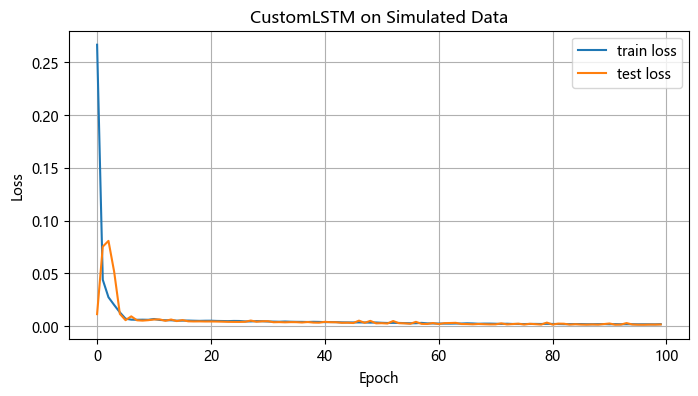

In [37]:
# 损失曲线
plt.figure(figsize=(8,4))
plt.plot(sim_train_loss, label='train loss')
plt.plot(sim_test_loss, label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CustomLSTM on Simulated Data')
plt.legend()
plt.grid(True)
plt.show()

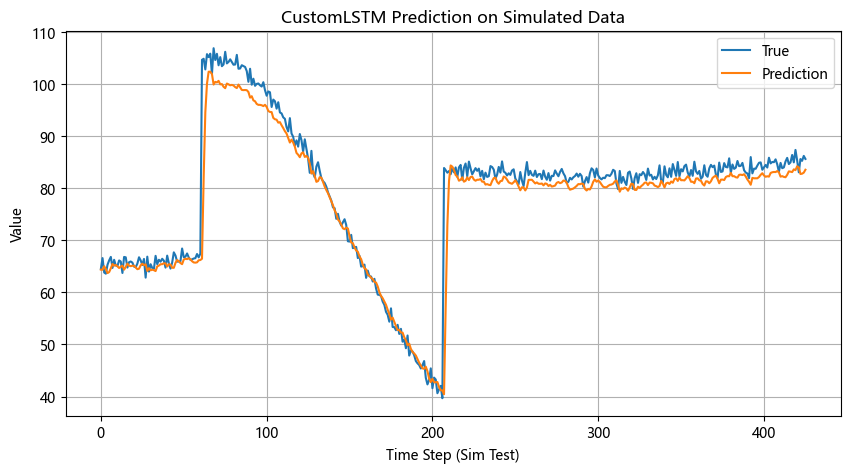

In [38]:
# 预测对比
sim_model.eval()
with torch.no_grad():
    sim_tx = torch.unsqueeze(sim_test_x, dim=2).to(device)
    sim_pred = sim_model(sim_tx).cpu().numpy()
sim_pred = sim_pred * (sim_train.max() - sim_train.min()) + sim_train.min()
sim_true = sim_test_y.numpy() * (sim_train.max() - sim_train.min()) + sim_train.min()
sim_pred_flat = sim_pred.flatten()
sim_true_flat = sim_true.flatten()

plt.figure(figsize=(10,5))
plt.plot(sim_true_flat, label='True')
plt.plot(sim_pred_flat, label='Prediction')
plt.xlabel('Time Step (Sim Test)')
plt.ylabel('Value')
plt.title('CustomLSTM Prediction on Simulated Data')
plt.grid(True)
plt.legend()
plt.show()